Blog link: http://www.bradfordlynch.com/blog/2015/12/04/InvestmentPortfolioOptimization.html

In [69]:
from pandas_datareader import data, wb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [72]:
plt.rcParams['figure.figsize'] = 10, 10

# The general idea of portfolio theory is *choosing the least risky portfolio mix that will achieve the same return*

# Review of mean and variance:

## If we observe a single asset over $n$-periods, we can calculate the following statistical measures:

## Mean asset return: $\bar{r} = \left ( (1+r_{1})\cdot(1-r_{2})\cdot ...(1-r_{2}) \right )^{1/n} - 1 = \left ( \prod (1+r_{i}) \right )^{1/n} -1$

- **Note**: this is the geometric return

## Variance of asset returns: $\sigma^{2}_{r} = \frac{(r_{1} - \bar{r})^{2} + (r_{2} - \bar{r})^{2} + ... + (r_{n} - \bar{r})^{2}}{n} = \frac{1}{n}\sum (r_{i} - \bar{r})^{2}$

## Now, extending our portfolio to more than one asset, we need to take correlations into account:

### Note: we now have $m$ assets and $n$ observations, so we need to consider the weights of each asset at time $t=0$

## Mean portfolio return: $\bar{r_{p}} = w_{1}\bar{r_{1}}+w_{2}\bar{r_{2}}+...+w_{m}\bar{r_{m}} = \sum w_{i}\bar{r_{i}}$

## Variance of portfolio returns: $\sigma_{p} = \sum_{i=1}^{m}\sum_{j=1}^{m}w_{i}w_{j}\rho_{i,j}\sigma_{i}\sigma_{j}$

#### Here, $\rho_{i,j}$ is the correlation between assets $i$ and $j$ and can be calculated as$\rho_{i,j} = \frac{Cov(i,j)}{\sigma_{i}\sigma_{j}}$ and $Cov(i,j) = E[r_{i}\cdot r_{j}] - E[r_{i}\cdot r_{j}]$

_____

# Aside

## Before we get into the heavy duty stuff, let's show that these relationships are true on some real financial data

### We'll use `pandas_datareader` to import the adjusted closing price for Google, Toyota, Coke and Pepsi

In [2]:
list_assets = ['GOOGL', 'TM', 'KO', 'PEP']
start = '2010-01-01'
end = '2015-10-31'
df = data.DataReader(list_assets, 'yahoo', start=start, end=end).loc[:,'Adj Close']

In [3]:
df.head()

Symbols,GOOGL,KO,PEP,TM
Date,,,,
2010-01-04,313.688690,20.236887,46.964394,66.913338
2010-01-05,312.307312,19.992081,47.531902,65.883041
2010-01-06,304.434448,19.984987,47.056435,66.724564
2010-01-07,297.347351,19.935318,46.757347,65.898781
2010-01-08,301.311310,19.566349,46.603962,67.448112


### If we pick Google as our first asset, and we want to know the average return over the period, we can either:

#### 1. Take the ratio between the growth in price and the beginning price, and divide it by the number of observations

#### 2. Use the formula above for mean asset return

- We'll show calculate the first return first

In [4]:
df['GOOGL'].iloc[-1], df['GOOGL'].iloc[0], len(df['GOOGL'])

(737.3900146484375, 313.6886901855469, 1468)

### So our beginning value was 313.69, our ending value was 737.39, and this growth occurred over 1468 periods

### Therefore, our return is calculated as:

In [5]:
((df['GOOGL'].iloc[-1])/df['GOOGL'].iloc[0])**(1/len(df['GOOGL']))-1

0.0005824010574886351

### So our average daily return was about 0.0582%

- Now, we'll calculate it the second way (the formula for mean asset return)

In [6]:
((df['GOOGL']/df['GOOGL'].shift(1)).prod())**(1/len(df['GOOGL']))-1

0.0005824010574886351

## As we can see, we get the same result

## Now, we'll use this return to calculate the variance of the returns

- we'll hardcode some of these guys for simplicity

In [7]:
series_daily_returns = df['GOOGL']/df['GOOGL'].shift(1)
r_mean = (series_daily_returns.prod())**(1/len(series_daily_returns))-1

In [8]:
r_sigma = ((series_daily_returns-r_mean-1)**2).mean()

In [9]:
r_sigma

0.00026338724767035375

- We can compare this value to the out-of-the-box variance method from python

In [10]:
series_daily_returns.var()

0.0002635498789447685

## We can see, we get the same result

### Note: in the first calculation, we needed to subtract one from the `series_daily_returns` but not from the second calculation. *WHY?*

- This is because the values in `series_daily_returns` are the $(1+r_{i})$ values, so if we want the deviation from the mean, we'd either need to use $(1+\bar{r})$ as the mean, or subtract the 1 out of each $(1+r_{i})$ term in the series

# Now, let's build a portfolio and show that the formulas above are correct

## Let's assume that on day 1, we bought 1 share of Google, 2 shares of Toyota, 3 shares of Coke, and 4 shares of Pepsi

In [11]:
first_row = df.index[0]
starting_total = 1*df.loc[first_row, 'GOOGL'] + 2*df.loc[first_row, 
                                                         'KO'] + 3*df.loc[first_row, 'PEP'] + 4*df.loc[first_row, 'TM']

In [12]:
starting_total

762.7089958190918

In [13]:
last_row = df.index[-1]
ending_total = 1*df.loc[last_row, 'GOOGL'] + 2*df.loc[last_row, 
                                                         'KO'] + 3*df.loc[last_row, 'PEP'] + 4*df.loc[last_row, 'TM']

In [14]:
ending_total

1537.3795318603516

## Our daily return can be calculated as:

In [15]:
(ending_total/starting_total)**(1/len(df))

1.0004776058971947

### Let's calculate this return the other way to show it's also equal to 0.04776%

In [16]:
df_returns = df/df.shift(1)
series_returns = df_returns.prod()

### We need to calculate the weights

In [17]:
series_weights = (df.loc[first_row]*[1,2,3,4])/starting_total

In [18]:
series_weights

Symbols
GOOGL    0.411282
KO       0.053066
PEP      0.184727
TM       0.350925
Name: 2010-01-04 00:00:00, dtype: float64

In [19]:
((series_returns*series_weights).sum())**(1/len(df))

1.0004776058971947

### Eyyyyy, the exact same

### Now, let's do it for the portfolio variance

In [20]:
df['portfolio'] = df['GOOGL'] + 2*df['KO'] + 3*df['PEP'] + 4*df['TM']

In [21]:
df_returns['portfolio'] = df['portfolio']/df['portfolio'].shift(1)

In [22]:
df_returns['portfolio'].var()

0.00010789152287555727

### Calculating it the other way...

In [23]:
df_corr = df_returns.corr()
df_corr

Symbols,GOOGL,KO,PEP,TM,portfolio
Symbols,,,,,
GOOGL,1.000000,0.335417,0.318484,0.308749,0.840925
KO,0.335417,1.000000,0.624003,0.397629,0.553433
PEP,0.318484,0.624003,1.000000,0.400365,0.589375
TM,0.308749,0.397629,0.400365,1.000000,0.741013
portfolio,0.840925,0.553433,0.589375,0.741013,1.000000


In [24]:
series_std = df_returns.std()
series_std

Symbols
GOOGL        0.016234
KO           0.009607
PEP          0.008935
TM           0.014030
portfolio    0.010387
dtype: float64

In [25]:
series_weights

Symbols
GOOGL    0.411282
KO       0.053066
PEP      0.184727
TM       0.350925
Name: 2010-01-04 00:00:00, dtype: float64

In [26]:
portfolio_var = 0

for asset1 in list_assets:
    for asset2 in list_assets:
        w1 = series_weights.loc[asset1]
        w2 = series_weights.loc[asset2]
        sigma1 = series_std.loc[asset1]
        sigma2 = series_std.loc[asset2]
        rho = df_corr.loc[asset1, asset2]
        val = w1*w2*rho*sigma1*sigma2
        portfolio_var += val

In [27]:
portfolio_var

0.00011096040952837303

### This seems pretty close. Probably only off because of rounding error

______

# Back to the portfolio optimization

### Let's loop through all the combinations of different portfolio weights to see the expected return and variance

In [39]:
df_weights = pd.DataFrame(columns = ['w1','w2','w3','w4'])

i = 0
for w1 in np.arange(0,1.05, 0.05):
    top1 = round((1.05-w1), 2)
    for w2 in np.arange(0, top1, 0.05):
        top2 = round((1.05-(w1+w2)), 2)
        for w3 in np.arange(0, top2, 0.05):
            w4 = abs(round((1.00-(w1+w2+w3)), 2))
            df_weights.loc[i] = [w1, w2, w3, w4]
            i += 1

### Now, we'll convert returns to monthly and calculate the expected return and variance of each portfolio

In [40]:
df_monthly = df.iloc[:,:-1].resample('M').last()
df_returns_monthly = (df_monthly/df_monthly.shift(1)).dropna()

In [41]:
series_monthly_returns = (df_returns_monthly.prod())**(1/len(df_returns_monthly))
series_monthly_returns

Symbols
GOOGL    1.014929
KO       1.010047
PEP      1.010430
TM       1.008774
dtype: float64

In [42]:
series_montly_std = df_returns_monthly.std()

In [43]:
series_montly_std

Symbols
GOOGL    0.074715
KO       0.041253
PEP      0.034632
TM       0.056326
dtype: float64

In [44]:
df_weights['mean return'] = (df_weights*series_monthly_returns.values).sum(axis=1)

In [45]:
df_corr = df_returns_monthly.corr()
df_corr

Symbols,GOOGL,KO,PEP,TM
Symbols,,,,
GOOGL,1.000000,0.299392,0.190546,0.230602
KO,0.299392,1.000000,0.630792,0.166327
PEP,0.190546,0.630792,1.000000,0.176827
TM,0.230602,0.166327,0.176827,1.000000


In [46]:
dict_corr = {}

for i, asset1 in enumerate(df_corr.index):
    for j, asset2 in enumerate(df_corr.columns):
        dict_corr[(i,j)] = df_corr.loc[asset1, asset2]

In [47]:
dict_sd = dict(enumerate(series_montly_std.values))

def calc_var(w):
    dict_w = dict(enumerate(w))
    var = 0
    for i in range(4):
        for j in range(4):
            w_i = dict_w[i]
            w_j = dict_w[j]
            sigma_i = dict_sd[i]
            sigma_j = dict_sd[j]
            rho_ij = dict_corr[(i,j)]
            val = w_i*w_j*sigma_i*sigma_j*rho_ij
            var += val
    return var

In [48]:
df_weights['variance'] = df_weights[['w1','w2','w3','w4']].apply(calc_var, axis=1)

### Let's annualize these returns and variances so they make a bit more sense

In [59]:
df_weights['mean return annual'] = (df_weights['mean return']**12)-1
df_weights['variance annual'] = df_weights['variance']*12

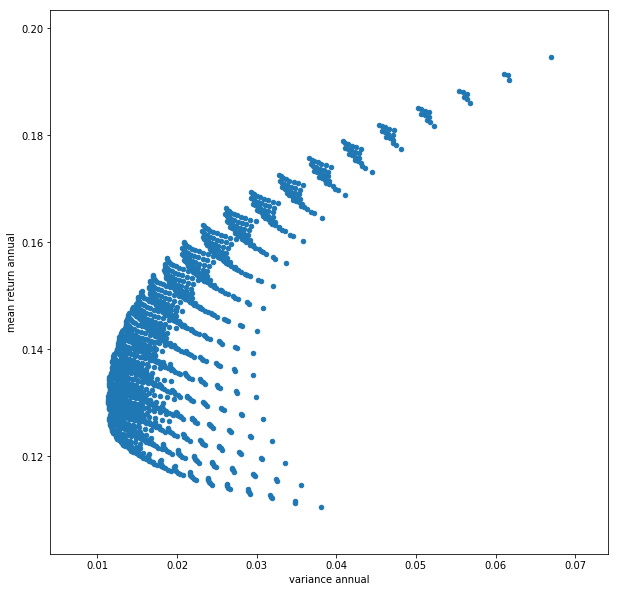

In [60]:
df_weights.plot.scatter(x='variance annual', y='mean return annual')

### We can include the Sharpe Ratio is our analysis and superimpose it over our plot

### Let's assume an RFR of 5%

In [64]:
df_weights['Sharpe Ratio'] = (df_weights['mean return annual']-0.05)/np.sqrt(df_weights['variance annual'])

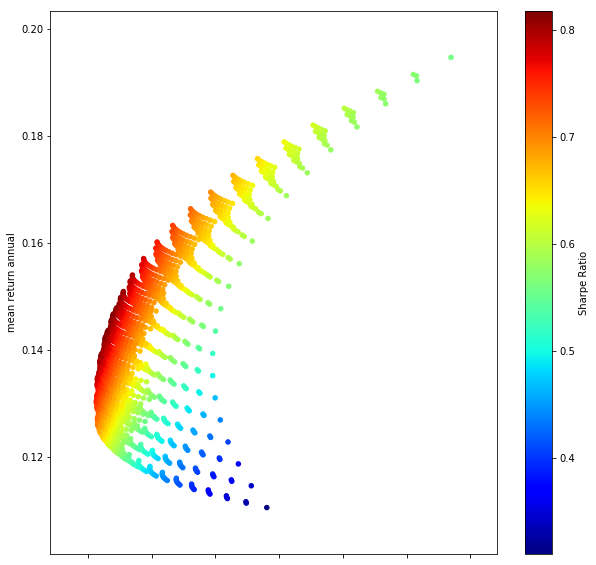

In [74]:
df_weights.plot.scatter(x='variance annual', y='mean return annual', c = 'Sharpe Ratio', colormap = cm.jet)
plt.show()